# 利用WGAN生成DeepFool对抗样本_picture-demo

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\ANACONDA\envs\python374\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

# 导入数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

# image load
from tflearn.data_utils import image_preloader
from tflearn.data_utils import shuffle
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

train_dataset_file = './DeepFool_baleful_pngs.txt'
X,Y = image_preloader(train_dataset_file, image_shape=(9,9),mode='file',normalize=True, categorical_labels=True, grayscale=True)
X = shuffle(X)[0]

print(np.shape(X))

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
(60000, 9, 9, 1)


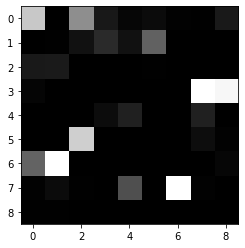

In [3]:
img = X[100]
# img = mnist.train.images[50]
plt.imshow(img.reshape((9, 9)), cmap='Greys_r')

# 构建模型

- inputs
- generator
- descriminator
- loss && optimizer

## Inputs

In [4]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

## generator

In [5]:
def get_generator(noise_img, out_dim, n_units, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的输入
    out_dim: 生成器输出tensor的size，这里应该为9*9=81
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
    
# #         network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")  #卷积处理3*3*32
# #         network = max_pool_2d(network, 2)  #池化处理2*2
# #         network = local_response_normalization(network)  #标准化张量    

#         network = fully_connected(network, 64, activation='tanh')
#         network = fully_connected(network, 32, activation='tanh')
#         network = fully_connected(network, 10, activation='tanh')
#         network = dropout(network, 0.2)
#         network = fully_connected(network, 2, activation='softmax')
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        
        outputs = tf.tanh(logits)
        # outputs = tf.sigmoid(logits)
        
        return logits, outputs

## Discriminator

In [6]:
# image load
from tflearn.data_utils import image_preloader
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

# network build
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

# img_prep = ImagePreprocessing()
# img_prep.add_featurewise_zero_center()
# img_prep.add_featurewise_stdnorm()
# img_aug = ImageAugmentation()
    
def get_discriminator(img, n_units, reuse, alpha=0.01):
    """
    判别器
    
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """

    with tf.variable_scope("discriminator", reuse=reuse):
        
        # hidden layer
        
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # Building convolutional network
    
        logits = tf.layers.dense(hidden1, 1)
        
        outputs = logits
        
#         network = input_data(shape=[None, 81], placeholder=img, name='input')
    
#         network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")  #卷积处理3*3*32
#         network = max_pool_2d(network, 2)  #池化处理2*2
#         network = local_response_normalization(network)  #标准化张量    

#         network = fully_connected(network, 64, activation='tanh')
#         network = fully_connected(network, 32, activation='tanh')
#         network = fully_connected(network, 10, activation='tanh')
#         network = dropout(network, 0.5)

#         network = fully_connected(network, 2, activation='softmax')
#         network = regression(network, optimizer='adam', learning_rate=0.01,
#                          loss='categorical_crossentropy', name='target')
        
#         logits = tf.layers.dense(network, 1)
#         outputs = tf.sigmoid(logits)
        
        return logits, outputs

## 定义参数

In [7]:
# 定义参数
# 真实图像的size
# img_size = mnist.train.images[0].shape[0]
img_size = pow(X[0].shape[0],2)

# 传入给generator的噪声size
noise_size = 10

# 生成器隐层参数
g_units = 128

# 判别器隐层参数
d_units = 64

# leaky ReLU的参数
d_alpha = 0.01

# learning_rate
learning_rate = 0.0001

# label smoothing
smooth = 0.1

## 构建网络

In [9]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
_, fake_img = get_generator(noise_img, img_size, g_units, reuse=False)

# discriminator
disc_real = get_discriminator(real_img, d_units, reuse=False)
disc_fake = get_discriminator(fake_img, d_units, reuse=True)

## Loss

这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。

- discriminator
discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。

- generator
generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。

In [10]:
# generator的loss
gen_cost = -tf.reduce_mean(disc_fake)

# discriminator的初始loss
# disc_cost = -tf.reduce_mean(disc_fake) + tf.reduce_mean(disc_real)
disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

# discriminator的loss的惩罚机制

# 设定batch_size
batch_size = 64
# 设定LAMBDA（惩罚比率%）
LAMBDA = 10.0

# shape = [tf.shape(real_img)[0], 1] # = [batch_size, 1]
# alpha = tf.random_uniform(shape=shape, minval=0., maxval=1.)
alpha = tf.random_uniform(shape=[batch_size, 1], minval=0., maxval=1.)

differences = fake_img - real_img
interpolates = real_img + (alpha * differences)

gradients = tf.gradients(get_discriminator(interpolates, d_units, reuse=True), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)
disc_cost += LAMBDA * gradient_penalty


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizer

由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

In [11]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
# disc_train_op = tf.train.AdamOptimizer(learning_rate).minimize(disc_cost,var_list=d_vars)
# gen_train_op = tf.train.AdamOptimizer(learning_rate).minimize(gen_cost,var_list=g_vars)

gen_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5,beta2=0.9).minimize(gen_cost,var_list=g_vars)
disc_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5,beta2=0.9).minimize(disc_cost,var_list=d_vars)

# 训练

In [12]:
import os

# 存储测试样例
samples = []
# 存储loss
losses = []
# 训练迭代轮数
epochs = 120
# 设定batch_size
batch_size = 64
# 抽取样本数
n_sample = 25

# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)

# train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for batch_i in range(len(X) // batch_size):
            batch = np.array(X[batch_i * batch_size: (batch_i + 1) * batch_size])

            img = batch.reshape((batch_size, 81))
            
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = img * 2 - 1
                        
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
#             # 一步到位直接Run optimizers并计算loss
#             for x in range(0, 5):
#                 _, d_loss = sess.run([disc_train_op, disc_cost], feed_dict={real_img: batch_images, noise_img: batch_noise})
#             _, g_loss = sess.run([gen_train_op, gen_cost], feed_dict={noise_img: batch_noise})
            
            # Run optimizers
        
            _ = sess.run(disc_train_op, feed_dict={real_img: batch_images, noise_img: batch_noise})
            
            # 更新n次disc才更新一次gen
            if batch_i % 1 == 0 :
                
                _ = sess.run(gen_train_op, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        d_loss = sess.run(disc_cost, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # generator loss
        g_loss = sess.run(gen_cost, 
                                feed_dict = {noise_img: batch_noise})
        
        print("Epoch {}/{}...".format(epoch+1, epochs),
              "Discriminator Loss: {:.4f}...".format(d_loss),
              "Generator Loss: {:.4f}".format(g_loss))  
        
        # 记录各类loss值
        losses.append((d_loss, g_loss))

        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, img_size, g_units, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)

        # 存储checkpoints
        saver.save(sess, './wgangp_DeepFool_ckpt/generator.ckpt')

# 将sample的生成数据记录下来
with open('./wgangp_DeepFool_ckpt/train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)                


Epoch 1/120... Discriminator Loss: -0.6667... Generator Loss: -1.7983
Epoch 2/120... Discriminator Loss: -0.1709... Generator Loss: -1.7016
Epoch 3/120... Discriminator Loss: -0.2026... Generator Loss: -1.6433
Epoch 4/120... Discriminator Loss: -0.1296... Generator Loss: -1.7971
Epoch 5/120... Discriminator Loss: -0.1361... Generator Loss: -1.7306
Epoch 6/120... Discriminator Loss: -0.2050... Generator Loss: -1.2677
Epoch 7/120... Discriminator Loss: -0.1811... Generator Loss: -0.7708
Epoch 8/120... Discriminator Loss: -0.1605... Generator Loss: -0.8660
Epoch 9/120... Discriminator Loss: -0.1625... Generator Loss: -0.7089
Epoch 10/120... Discriminator Loss: -0.1960... Generator Loss: -0.5682
Epoch 11/120... Discriminator Loss: -0.1802... Generator Loss: -0.6167
Epoch 12/120... Discriminator Loss: -0.1846... Generator Loss: -0.7185
Epoch 13/120... Discriminator Loss: -0.2269... Generator Loss: -0.8263
Epoch 14/120... Discriminator Loss: -0.1499... Generator Loss: -0.7933
Epoch 15/120..

Epoch 114/120... Discriminator Loss: -0.0885... Generator Loss: -0.2123
Epoch 115/120... Discriminator Loss: -0.1286... Generator Loss: -0.2598
Epoch 116/120... Discriminator Loss: -0.0922... Generator Loss: -0.3063
Epoch 117/120... Discriminator Loss: -0.1131... Generator Loss: -0.1748
Epoch 118/120... Discriminator Loss: -0.1146... Generator Loss: -0.2450
Epoch 119/120... Discriminator Loss: -0.1046... Generator Loss: -0.1559
Epoch 120/120... Discriminator Loss: -0.0827... Generator Loss: -0.1869


# 绘制loss曲线

E:\ANACONDA\envs\python374\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


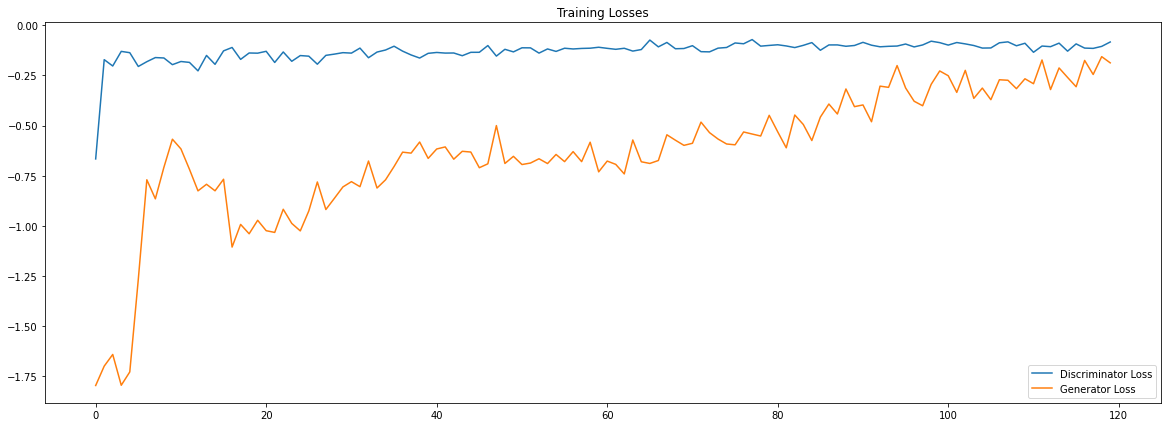

In [13]:
from Gan_tools import view_samples, view_process, adv_sample_legalization, loss_chart
loss_chart(losses)

# 显示图像

In [14]:
# Load samples from generator taken while training
with open('./wgangp_DeepFool_ckpt/train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

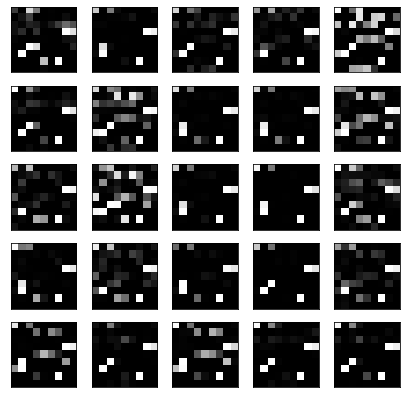

In [15]:
view_samples(samples, -1) # 显示最后一轮的outputs

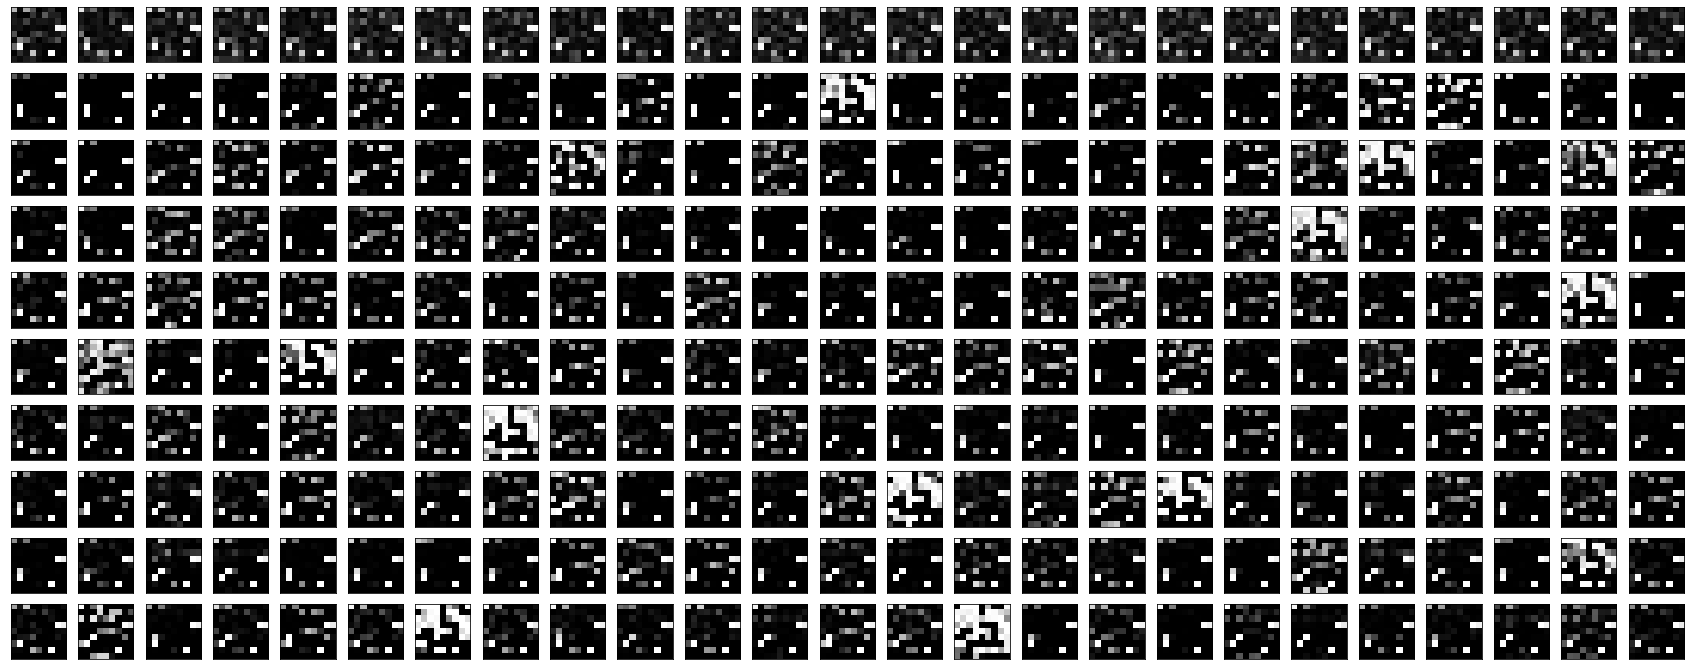

In [16]:
view_process(samples, 120)  # 显示整个生成过程图片

# 生成新的图片

In [17]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
# print(g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('wgangp_DeepFool_ckpt'))
    sample_noise = np.random.uniform(-1, 1, size=(25, 10))
    # print(sample_noise)
    gen_samples = sess.run(get_generator(noise_img, img_size, g_units, reuse=True),
                           feed_dict={noise_img: sample_noise})
    
print(np.shape(gen_samples)) # (2, 25, 81)
# 第一个下标固定为1，代表选的是outputs，而不是logits；第二个下标范围为0-24，代表选择25个样本中的一个
test = gen_samples[1][0].tolist()
print(len(test))
print(test)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from wgangp_DeepFool_ckpt\generator.ckpt
(2, 25, 81)
81
[0.2993805706501007, -0.9951549172401428, -0.2751498520374298, -0.9994319677352905, -1.0, -0.9999672770500183, -0.9999054074287415, -1.0, -0.9869224429130554, -1.0, -0.9717190861701965, -0.985653281211853, -0.14953431487083435, -0.9997045993804932, 0.17164480686187744, -0.2909037470817566, -0.9999992251396179, -0.9999999403953552, -0.9980205297470093, -0.9853097796440125, -0.999937891960144, -0.9989262819290161, -1.0, -0.9999058842658997, -0.9738197922706604, -0.9947648048400879, -0.9803341627120972, -0.9977323412895203, -0.9906237721443176, -0.9956929683685303, -0.9990050792694092, -1.0, -1.0, -1.0, 0.9323585033416748, 0.6581114530563354, -0.9894991517066956, -0.9989450573921204, -1.0, -0.5254113674163818, 0.1321471780538559, -0.12644781172275543, -0.7477911114692688, -0.9982022643089294, -0.997916042804718,

In [18]:
# 将生成的对抗样本合法化
adv_sample_legalization(test)    

[[55993.11, 8362.56, 10.95, 12074902.04, 8.58, 9.4, 616.88, 13621.45, 263.91, 18.71, 75.37, 92.72, 1791.26, 34.7, 695.0, 705.78, 1116399.82, 2129287.38, 6279167.14, 191746.1, 11671010.38, 2163344.49, 1951804.99, 6053213.88, 1245257.78, 9142846.61, 1751267.14, 984795.89, 3729586.86, 1066051.28, 0.05, 0.0, 0.0, 0.0, 2943266.38, 370788.02, 47071.18, 8127.85, 14.16, 1572.39, 381.21, 660.22, 941009.1, 0.01, 0.05, 0.0, 0.91, 0.29, 0.08, 0.0, 0.0, 0.74, 451.79, 73.87, 708.88, 2893542.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.58, 617.56, 9.56, 13621.47, 11950.9, 1984.0, 5.88, 399423.59, 95869.51, 39477.18, 169535.96, 73016.96, 4969173.88, 922675.56, 5629468.01, 4276788.12]]


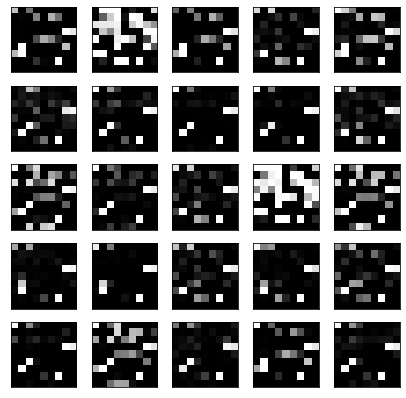

In [19]:
# 展示新生成的对抗样本图片
view_samples([gen_samples], 0)